# **Importing of Library**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import copy

# **Importing of Dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/OIDS/N-BaIoT Dataset.csv')

Mounted at /content/drive


# **Data Preprocessing**

## Dataset info

In [3]:
# dataset info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311913 entries, 0 to 311912
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   Flags                311913 non-null  int64
 1   Protocol             311913 non-null  int64
 2   Source Address       311913 non-null  int64
 3   Source port          311913 non-null  int64
 4   Direction            311913 non-null  int64
 5   Destination Address  311913 non-null  int64
 6   Destination port     311913 non-null  int64
 7   Total Packets        311913 non-null  int64
 8   Total Bytes          311913 non-null  int64
 9   State                311913 non-null  int64
 10  Labels               311913 non-null  int64
dtypes: int64(11)
memory usage: 26.2 MB


In [4]:
# Check for null values in dataset
data.isnull().sum()

,0
Flags,0
Protocol,0
Source Address,0
Source port,0
Direction,0
Destination Address,0
Destination port,0
Total Packets,0
Total Bytes,0
State,0


The dataset does not have any null values to be removed and thus can move to the next step of data preprocessing which is feature selection.

## Feature Selection

In [5]:
X = data.drop(['Labels'], axis=1)
y = data['Labels']

In [6]:
# confirmation of X axis
X

,Flags,Protocol,Source Address,Source port,Direction,Destination Address,Destination port,Total Packets,Total Bytes,State
0,72293,72316,72527,1040,74083,112673,5678,1725,1275426,114225
1,72288,72317,72527,1041,74087,82205,114190,3,317,114222
2,72288,72317,72527,1042,74087,82205,114190,3,412,114222
3,72304,72316,72527,1043,74083,112673,5678,20,5506,114225
4,72304,72316,72527,1044,74083,110981,114212,4,248,114230
...,...,...,...,...,...,...,...,...,...,...
311908,72298,72316,72645,44990,74083,109539,114195,8,651,114225
311909,72288,72316,72645,54396,74083,111184,114195,150,118655,114232
311910,72288,72317,72649,52441,74083,108512,1900,6,2360,114226
311911,72288,72317,72649,53139,74083,108512,1900,2,886,114226


In [7]:
# confirmation of y axis
y

,Labels
0,1
1,1
2,1
3,1
4,1
...,...
311908,0
311909,0
311910,0
311911,0


In [8]:
# check if the column is a column vector instead of a 1D array
print(y.shape)

(311913,)


In [9]:
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

In [10]:
print("Shape of X: ", X.shape)
print("Shape of y", y.shape)

Shape of X:  torch.Size([311913, 10])
Shape of y torch.Size([311913, 1])


## Splitting the Dataset

In [11]:
# train-temp split the dataset
# temp dataset to be used for test and validation split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, shuffle=True)

#test-val split from temp dataset
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, train_size=0.5, shuffle=True)

# The ratio of each split is train(0.7) : test (0.15) : validation (0.15)

#**Deep Neural Network Model**

## Model Training

In [12]:
class IoTModel(nn.Module):
    def __init__(self):
        super().__init__()
        # fully connected (linear) layers
        self.layer1 = nn.Linear(10, 10)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(10, 10)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(10,10)
        self.act3 = nn.ReLU()
        self.layer4 = nn.Linear(10, 10)
        self.act4 = nn.ReLU()
        self.output = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.act4(self.layer4(x))
        x = self.sigmoid(self.output(x))
        return x

In [13]:
def model_train_adam(model, X_train, y_train, X_val, y_val, patience=8):
    # loss function and optimizer
    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs   = 50                      # number of epochs to run
    batch_size = 25                       # adjust as you like
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model (by val accuracy)
    best_acc = -float("inf")
    best_val_loss = float("inf")
    best_weights = copy.deepcopy(model.state_dict())
    train_loss_history = []
    val_accuracy_history = []
    val_loss_history = []
    no_improve = 0

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0.0
        n_samples = 0

        # ---- training over batches ----
        for start in tqdm.tqdm(batch_start, unit="batch",
                               desc=f"Epoch {epoch+1}/{n_epochs}", leave=False):
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]

            # forward
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            # backward + update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # accumulate epoch loss
            epoch_loss += loss.item() * X_batch.size(0)
            n_samples += X_batch.size(0)

        avg_train_loss = epoch_loss / max(1, n_samples)

        # ---- validation at end of epoch ----
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val)
            val_loss = loss_fn(y_val_pred, y_val).item()
            val_acc = (y_val_pred.round() == y_val).float().mean().item()

        # ---- print per-epoch summary ----
        print(f"Epoch {epoch+1:03d}/{n_epochs} | "
              f"train_loss={avg_train_loss:.4f} | "
              f"val_loss={val_loss:.4f} | "
              f"val_acc={val_acc:.4f}")

        train_loss_history.append(avg_train_loss)
        val_accuracy_history.append(val_acc)
        val_loss_history.append(val_loss)

        # keep best weights (by val accuracy)
        if val_acc > best_acc:
            best_acc = val_acc
            best_weights = copy.deepcopy(model.state_dict())

        # --- Early stopping logic ---
        if val_loss < best_val_loss - 0.001:  # small tolerance
            best_val_loss = val_loss
            best_weights = copy.deepcopy(model.state_dict())
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"⏹ Early stopping triggered at epoch {epoch}")
                break


    # restore best model and return best accuracy and weights
    model.load_state_dict(best_weights)
    return best_acc, best_weights, train_loss_history, val_accuracy_history, val_loss_history

In [14]:
def model_train_adamw(model, X_train, y_train, X_val, y_val, patience=8):
    # loss function and optimizer
    loss_fn = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay= 0.01)

    n_epochs   = 50                      # number of epochs to run
    batch_size = 25                       # adjust as you like
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model (by val accuracy)
    best_acc = -float("inf")
    best_val_loss = float("inf")
    best_weights = copy.deepcopy(model.state_dict())
    train_loss_history = []
    val_accuracy_history = []
    val_loss_history = []
    no_improve = 0

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0.0
        n_samples = 0

        # ---- training over batches ----
        for start in tqdm.tqdm(batch_start, unit="batch",
                               desc=f"Epoch {epoch+1}/{n_epochs}", leave=False):
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]

            # forward
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            # backward + update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # accumulate epoch loss
            epoch_loss += loss.item() * X_batch.size(0)
            n_samples += X_batch.size(0)

        avg_train_loss = epoch_loss / max(1, n_samples)

        # ---- validation at end of epoch ----
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val)
            val_loss = loss_fn(y_val_pred, y_val).item()
            val_acc = (y_val_pred.round() == y_val).float().mean().item()

        # ---- print per-epoch summary ----
        print(f"Epoch {epoch+1:03d}/{n_epochs} | "
              f"train_loss={avg_train_loss:.4f} | "
              f"val_loss={val_loss:.4f} | "
              f"val_acc={val_acc:.4f}")

        train_loss_history.append(avg_train_loss)
        val_accuracy_history.append(val_acc)
        val_loss_history.append(val_loss)

        # keep best weights (by val accuracy)
        if val_acc > best_acc:
            best_acc = val_acc
            best_weights = copy.deepcopy(model.state_dict())

        # --- Early stopping logic ---
        if val_loss < best_val_loss - 0.001:  # small tolerance
            best_val_loss = val_loss
            best_weights = copy.deepcopy(model.state_dict())
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"⏹ Early stopping triggered at epoch {epoch}")
                break


    # restore best model and return best accuracy and weights
    model.load_state_dict(best_weights)
    return best_acc, best_weights, train_loss_history, val_accuracy_history, val_loss_history

In [15]:
def model_train_sgd(model, X_train, y_train, X_val, y_val, patience=8):
    # loss function and optimizer
    loss_fn = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)

    n_epochs   = 50                      # number of epochs to run
    batch_size = 25                       # adjust as you like
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model (by val accuracy)
    best_acc = -float("inf")
    best_val_loss = float("inf")
    best_weights = copy.deepcopy(model.state_dict())
    train_loss_history = []
    val_accuracy_history = []
    val_loss_history = []
    no_improve = 0

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0.0
        n_samples = 0

        # ---- training over batches ----
        for start in tqdm.tqdm(batch_start, unit="batch",
                               desc=f"Epoch {epoch+1}/{n_epochs}", leave=False):
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]

            # forward
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            # backward + update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # accumulate epoch loss
            epoch_loss += loss.item() * X_batch.size(0)
            n_samples += X_batch.size(0)

        avg_train_loss = epoch_loss / max(1, n_samples)

        # ---- validation at end of epoch ----
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val)
            val_loss = loss_fn(y_val_pred, y_val).item()
            val_acc = (y_val_pred.round() == y_val).float().mean().item()

        # ---- print per-epoch summary ----
        print(f"Epoch {epoch+1:03d}/{n_epochs} | "
              f"train_loss={avg_train_loss:.4f} | "
              f"val_loss={val_loss:.4f} | "
              f"val_acc={val_acc:.4f}")

        train_loss_history.append(avg_train_loss)
        val_accuracy_history.append(val_acc)
        val_loss_history.append(val_loss)

        # keep best weights (by val accuracy)
        if val_acc > best_acc:
            best_acc = val_acc
            best_weights = copy.deepcopy(model.state_dict())

        # --- Early stopping logic ---
        if val_loss < best_val_loss - 0.001:  # small tolerance
            best_val_loss = val_loss
            best_weights = copy.deepcopy(model.state_dict())
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"⏹ Early stopping triggered at epoch {epoch}")
                break


    # restore best model and return best accuracy and weights
    model.load_state_dict(best_weights)
    return best_acc, best_weights, train_loss_history, val_accuracy_history, val_loss_history

In [16]:
model = IoTModel()
print(model.parameters)


<bound method Module.parameters of IoTModel(
  (layer1): Linear(in_features=10, out_features=10, bias=True)
  (act1): ReLU()
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (act2): ReLU()
  (layer3): Linear(in_features=10, out_features=10, bias=True)
  (act3): ReLU()
  (layer4): Linear(in_features=10, out_features=10, bias=True)
  (act4): ReLU()
  (output): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)>


In [17]:
# Train model with Adam optimizer
acc, weights, train_loss_history, val_accuracy_history, val_loss_history = model_train_adam(model, X_train, y_train, X_val, y_val)

# saving the history values for each optimizer
adam_best_acc = acc
adam_best_weights = weights
adam_train_loss_history = train_loss_history
adam_val_accuracy_history = val_accuracy_history
adam_val_loss_history = val_loss_history

print(f"\nBest validation accuracy for model with Adam optimizer: {adam_best_acc:.2%}")

Epoch 001/50 | train_loss=50.6740 | val_loss=51.2087 | val_acc=0.4879


Epoch 002/50 | train_loss=50.6740 | val_loss=51.2087 | val_acc=0.4879


Epoch 003/50 | train_loss=50.6740 | val_loss=51.2087 | val_acc=0.4879


Epoch 004/50 | train_loss=50.6740 | val_loss=51.2087 | val_acc=0.4879


Epoch 005/50 | train_loss=50.6740 | val_loss=51.2087 | val_acc=0.4879


Epoch 006/50 | train_loss=50.6740 | val_loss=51.2087 | val_acc=0.4879


Epoch 007/50 | train_loss=50.6740 | val_loss=51.2087 | val_acc=0.4879


Epoch 008/50 | train_loss=50.6740 | val_loss=51.2087 | val_acc=0.4879


Epoch 009/50 | train_loss=50.6740 | val_loss=51.2087 | val_acc=0.4879
⏹ Early stopping triggered at epoch 8

Best validation accuracy for model with Adam optimizer: 48.79%


In [18]:
# Train model with AdamW optimizer
acc, weights, train_loss_history, val_accuracy_history, val_loss_history = model_train_adamw(model, X_train, y_train, X_val, y_val)

# saving the history values for each optimizer
adamw_best_acc = acc
adamw_best_weights = weights
adamw_train_loss_history = train_loss_history
adamw_val_accuracy_history = val_accuracy_history
adamw_val_loss_history = val_loss_history

print(f"\nBest validation accuracy for model with AdamW optimizer: {adamw_best_acc:.2%}")

Epoch 001/50 | train_loss=50.6740 | val_loss=51.2087 | val_acc=0.4879


Epoch 002/50 | train_loss=50.6740 | val_loss=51.2087 | val_acc=0.4879


Epoch 003/50 | train_loss=50.6740 | val_loss=51.2087 | val_acc=0.4879


Epoch 004/50 | train_loss=50.6740 | val_loss=51.2087 | val_acc=0.4879


Epoch 005/50 | train_loss=50.6740 | val_loss=51.2087 | val_acc=0.4879


Epoch 006/50 | train_loss=50.6740 | val_loss=51.2087 | val_acc=0.4879


Epoch 007/50 | train_loss=50.6740 | val_loss=51.2087 | val_acc=0.4879


Epoch 008/50 | train_loss=50.6740 | val_loss=51.2068 | val_acc=0.4879


Epoch 009/50 | train_loss=50.6740 | val_loss=51.2087 | val_acc=0.4879


Epoch 010/50 | train_loss=50.6740 | val_loss=51.2087 | val_acc=0.4879


Epoch 011/50 | train_loss=50.6740 | val_loss=51.2068 | val_acc=0.4879


Epoch 012/50 | train_loss=24.6183 | val_loss=0.0234 | val_acc=0.9951


Epoch 013/50 | train_loss=0.0395 | val_loss=0.0268 | val_acc=0.9908


Epoch 014/50 | train_loss=0.0441 | val_loss=0.0260 | val_acc=0.9950


Epoch 015/50 | train_loss=0.0430 | val_loss=0.0216 | val_acc=0.9949


Epoch 016/50 | train_loss=0.0383 | val_loss=0.0231 | val_acc=0.9949


Epoch 017/50 | train_loss=0.0305 | val_loss=0.0217 | val_acc=0.9960


Epoch 018/50 | train_loss=0.0222 | val_loss=0.0358 | val_acc=0.9973


Epoch 019/50 | train_loss=0.0503 | val_loss=0.0980 | val_acc=0.9975


Epoch 020/50 | train_loss=0.0351 | val_loss=0.0455 | val_acc=0.9969


Epoch 021/50 | train_loss=0.0578 | val_loss=0.0187 | val_acc=0.9974


Epoch 022/50 | train_loss=0.0293 | val_loss=0.0167 | val_acc=0.9973


Epoch 023/50 | train_loss=0.0549 | val_loss=0.0184 | val_acc=0.9975


Epoch 024/50 | train_loss=0.0299 | val_loss=0.0178 | val_acc=0.9975


Epoch 025/50 | train_loss=0.3756 | val_loss=0.1155 | val_acc=0.9908


Epoch 026/50 | train_loss=0.1011 | val_loss=0.0376 | val_acc=0.9909


Epoch 027/50 | train_loss=0.0421 | val_loss=0.0412 | val_acc=0.9903


Epoch 028/50 | train_loss=0.0421 | val_loss=0.0393 | val_acc=0.9907


Epoch 029/50 | train_loss=0.0414 | val_loss=0.0376 | val_acc=0.9909


Epoch 030/50 | train_loss=0.0426 | val_loss=0.0363 | val_acc=0.9911
⏹ Early stopping triggered at epoch 29

Best validation accuracy for model with AdamW optimizer: 99.75%


In [19]:
# Train model with SGD optimizer
acc, weights, train_loss_history, val_accuracy_history, val_loss_history = model_train_sgd(model, X_train, y_train, X_val, y_val)

# saving the history values for each optimizer
sgd_best_acc = acc
sgd_best_weights = weights
sgd_train_loss_history = train_loss_history
sgd_val_accuracy_history = val_accuracy_history
sgd_val_loss_history = val_loss_history

print(f"\nBest validation accuracy for model with SGD optimizer: {sgd_best_acc:.2%}")

Epoch 001/50 | train_loss=0.6973 | val_loss=0.6927 | val_acc=0.5121


Epoch 002/50 | train_loss=0.6932 | val_loss=0.6928 | val_acc=0.5121


Epoch 003/50 | train_loss=0.6932 | val_loss=0.6928 | val_acc=0.5121


Epoch 004/50 | train_loss=0.6932 | val_loss=0.6928 | val_acc=0.5121


Epoch 005/50 | train_loss=0.6932 | val_loss=0.6928 | val_acc=0.5121


Epoch 006/50 | train_loss=0.6932 | val_loss=0.6928 | val_acc=0.5121


Epoch 007/50 | train_loss=0.6932 | val_loss=0.6928 | val_acc=0.5121


Epoch 008/50 | train_loss=0.6932 | val_loss=0.6928 | val_acc=0.5121


Epoch 009/50 | train_loss=0.6932 | val_loss=0.6928 | val_acc=0.5121
⏹ Early stopping triggered at epoch 8

Best validation accuracy for model with SGD optimizer: 51.21%


## Model Evaluation

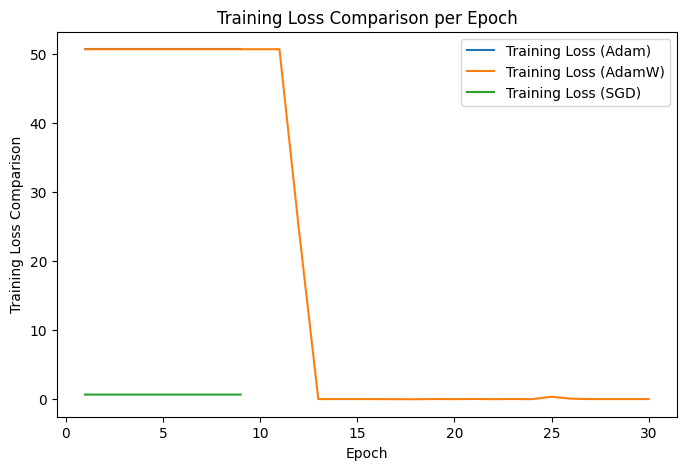

In [20]:
import matplotlib.pyplot as plt

def plot_history(histories, labels, title):
    plt.figure(figsize=(20, 5) if max([len(h) for h in histories]) > 30 else (8, 5))
    epochs = [range(1, len(history) + 1) for history in histories]
    for i, history in enumerate(histories):
        plt.plot(epochs[i], history, label=labels[i])
    plt.xlabel("Epoch")
    plt.ylabel(title)
    plt.title(f"{title} per Epoch")
    plt.legend()
    plt.show()

train_loss_histories = [
    adam_train_loss_history,
    adamw_train_loss_history,
    sgd_train_loss_history,
]

labels = [
    "Training Loss (Adam)",
    "Training Loss (AdamW)",
    "Training Loss (SGD)",
]

# Plotting Model Training Loss
plot_history(train_loss_histories, labels, "Training Loss Comparison")

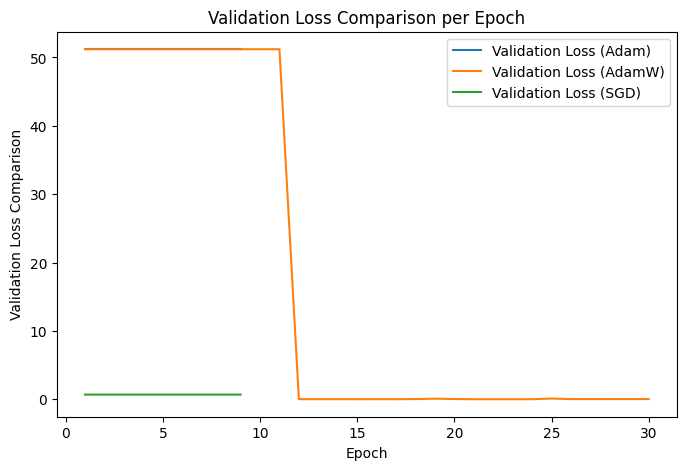

In [21]:
val_loss_histories = [
    adam_val_loss_history,
    adamw_val_loss_history,
    sgd_val_loss_history,
]

labels = [
    "Validation Loss (Adam)",
    "Validation Loss (AdamW)",
    "Validation Loss (SGD)",
]

# Plotting Model Validation Loss
plot_history(val_loss_histories, labels, "Validation Loss Comparison")

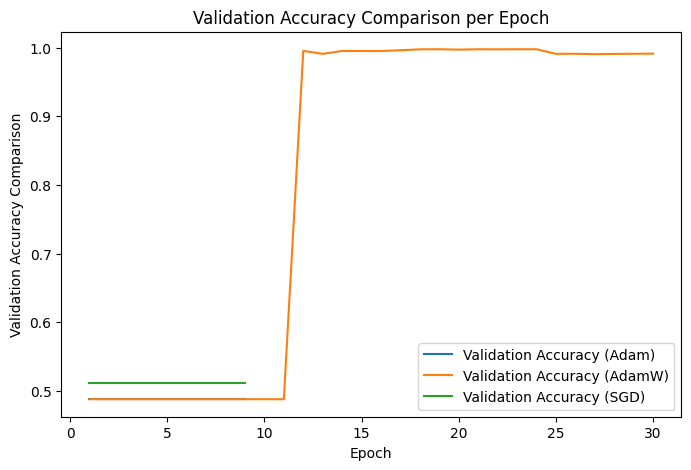

In [22]:
accuracy_histories = [
    adam_val_accuracy_history,
    adamw_val_accuracy_history,
    sgd_val_accuracy_history,
]

labels = [
    "Validation Accuracy (Adam)",
    "Validation Accuracy (AdamW)",
    "Validation Accuracy (SGD)",
]

# Plotting Model Validation Accuracy
plot_history(accuracy_histories, labels, "Validation Accuracy Comparison")

In [23]:
# Compare Best Accuracy
print(f"\nBest validation accuracy for model with Adam optimizer: {adam_best_acc:.2%}")
print(f"\nBest validation accuracy for model with AdamW optimizer: {adamw_best_acc:.2%}")
print(f"\nBest validation accuracy for model with SGD optimizer: {sgd_best_acc:.2%}")


Best validation accuracy for model with Adam optimizer: 48.79%

Best validation accuracy for model with AdamW optimizer: 99.75%

Best validation accuracy for model with SGD optimizer: 51.21%


## Evaluating of test dataset

In [24]:
def evaluate_model(model, X_test, y_test, model_weights=None):

    loss_fn = nn.BCELoss()

    if model_weights:
        model.load_state_dict(model_weights)

    model.eval()
    with torch.no_grad():
      y_test_pred = model(X_test)
      test_loss = loss_fn(y_test_pred, y_test)
      test_acc = (y_test_pred.round() == y_test).float().mean().item()

    return {"test_loss": test_loss.item(), "test_accuracy": test_acc}

In [25]:
metrics = evaluate_model(model, X_test, y_test, adamw_best_weights)
print(metrics)

{'test_loss': 0.015622919425368309, 'test_accuracy': 0.9972642064094543}


## Testing the prediction

Testing the model to confirm the correct prediction of the model.

In [26]:
pos_indices = (y_test == 1).nonzero(as_tuple=True)[0]
neg_indices = (y_test == 0).nonzero(as_tuple=True)[0]

pos_sample = pos_indices[torch.randperm(len(pos_indices))[:2]]
neg_sample = neg_indices[torch.randperm(len(neg_indices))[:3]]

# combine them
mixed_indices = torch.cat([pos_sample, neg_sample])

X_sample = X_test[mixed_indices]
y_sample = y_test[mixed_indices]

In [27]:
model.eval()
with torch.no_grad():
    probs = model(X_sample).squeeze()    # predicted probabilities
    preds = (probs >= 0.5).long()

In [28]:
for i in range(len(mixed_indices)):
    print(f"Sample {i+1}: True = {y_sample[i].item()}, Pred = {preds[i].item()}, Prob = {probs[i].item():.4f}")


Sample 1: True = 1.0, Pred = 1, Prob = 0.9865
Sample 2: True = 1.0, Pred = 1, Prob = 1.0000
Sample 3: True = 0.0, Pred = 0, Prob = 0.0000
Sample 4: True = 0.0, Pred = 0, Prob = 0.0000
Sample 5: True = 0.0, Pred = 0, Prob = 0.0000


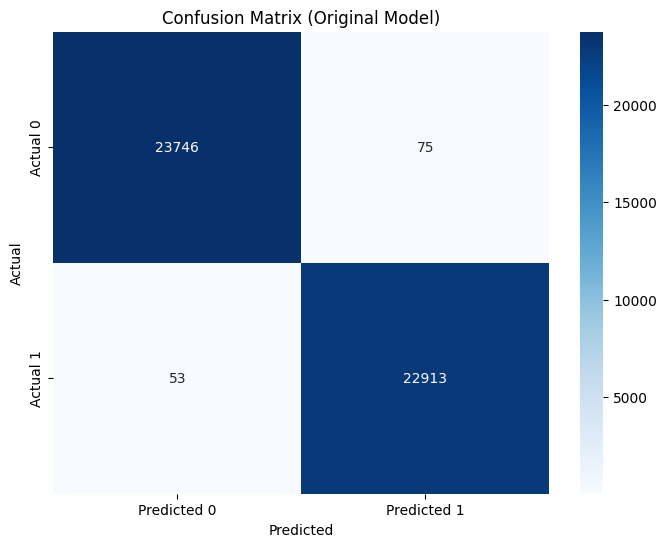

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the best weights for the AdamW optimizer
model = IoTModel()  # Make sure to use the correct model class
model.load_state_dict(adamw_best_weights)
model.eval()

# Make predictions on the original test set (before scaling)
with torch.no_grad():
    y_pred_probs = model(X_test).squeeze()
    y_pred = (y_pred_probs >= 0.5).long()

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Original Model)')
plt.show()

#**Improving Accuracy**

## Scalling

In [30]:
# looking into the mean and std for scalling
data.describe()

,Flags,Protocol,Source Address,Source port,Direction,Destination Address,Destination port,Total Packets,Total Bytes,State,Labels
count,311913.000000,311913.000000,311913.000000,311913.000000,311913.000000,311913.000000,311913.000000,311913.000000,3.119130e+05,311913.000000,311913.000000
mean,72294.476264,72316.204874,72562.569505,28886.371376,74084.542177,91386.813900,103581.575856,12.275183,6.281414e+03,114225.123451,0.492099
std,7.683393,0.861789,171.149301,25187.747115,2.147058,11853.982721,32288.328367,107.528281,1.131069e+05,204.558015,0.499938
min,72288.000000,72312.000000,72318.000000,0.000000,74082.000000,74091.000000,0.000000,0.000000,0.000000e+00,3.000000,0.000000
25%,72288.000000,72316.000000,72527.000000,2343.000000,74083.000000,83135.000000,114190.000000,2.000000,1.800000e+02,114222.000000,0.000000
50%,72288.000000,72316.000000,72527.000000,36056.000000,74083.000000,83901.000000,114193.000000,3.000000,2.830000e+02,114225.000000,0.000000
75%,72304.000000,72317.000000,72645.000000,51558.000000,74087.000000,103526.000000,114199.000000,6.000000,5.940000e+02,114230.000000,1.000000
max,72311.000000,72317.000000,73966.000000,74081.000000,74090.000000,113217.000000,114219.000000,31142.000000,3.216380e+07,114239.000000,1.000000


In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

X_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_scaled = torch.tensor(X_val_scaled, dtype=torch.float32)

In [32]:
# train the model

model = IoTModel()
acc, weights, train_loss_history, val_accuracy_history, val_loss_history = model_train_adamw(model, X_train_scaled, y_train, X_val_scaled, y_val)

scaled_best_acc = acc
scaled_best_weights = weights
scaled_train_loss_history = train_loss_history
scaled_val_accuracy_history = val_accuracy_history
scaled_val_loss_history = val_loss_history

print(f"\nBest validation accuracy: {scaled_best_acc:.2%}")

Epoch 001/50 | train_loss=0.0293 | val_loss=0.0074 | val_acc=0.9984


Epoch 002/50 | train_loss=0.0058 | val_loss=0.0053 | val_acc=0.9987


Epoch 003/50 | train_loss=0.0044 | val_loss=0.0058 | val_acc=0.9985


Epoch 004/50 | train_loss=0.0044 | val_loss=0.0066 | val_acc=0.9990


Epoch 005/50 | train_loss=0.0032 | val_loss=0.0058 | val_acc=0.9994


Epoch 006/50 | train_loss=0.0023 | val_loss=0.0045 | val_acc=0.9996


Epoch 007/50 | train_loss=0.0023 | val_loss=0.0043 | val_acc=0.9996


Epoch 008/50 | train_loss=0.0017 | val_loss=0.0043 | val_acc=0.9996


Epoch 009/50 | train_loss=0.0015 | val_loss=0.0039 | val_acc=0.9996


Epoch 010/50 | train_loss=0.0013 | val_loss=0.0036 | val_acc=0.9997


Epoch 011/50 | train_loss=0.0011 | val_loss=0.0037 | val_acc=0.9996


Epoch 012/50 | train_loss=0.0016 | val_loss=0.0035 | val_acc=0.9997


Epoch 013/50 | train_loss=0.0012 | val_loss=0.0035 | val_acc=0.9997


Epoch 014/50 | train_loss=0.0010 | val_loss=0.0032 | val_acc=0.9997


Epoch 015/50 | train_loss=0.0015 | val_loss=0.0031 | val_acc=0.9998


Epoch 016/50 | train_loss=0.0009 | val_loss=0.0031 | val_acc=0.9998


Epoch 017/50 | train_loss=0.0009 | val_loss=0.0030 | val_acc=0.9998


Epoch 018/50 | train_loss=0.0010 | val_loss=0.0030 | val_acc=0.9998


Epoch 019/50 | train_loss=0.0008 | val_loss=0.0008 | val_acc=0.9998


Epoch 020/50 | train_loss=0.0010 | val_loss=0.0030 | val_acc=0.9997


Epoch 021/50 | train_loss=0.0009 | val_loss=0.0029 | val_acc=0.9998


Epoch 022/50 | train_loss=0.0009 | val_loss=0.0031 | val_acc=0.9997


Epoch 023/50 | train_loss=0.0014 | val_loss=0.0030 | val_acc=0.9998


Epoch 024/50 | train_loss=0.0008 | val_loss=0.0030 | val_acc=0.9997


Epoch 025/50 | train_loss=0.0010 | val_loss=0.0030 | val_acc=0.9997


Epoch 026/50 | train_loss=0.0009 | val_loss=0.0031 | val_acc=0.9998


Epoch 027/50 | train_loss=0.0013 | val_loss=0.0029 | val_acc=0.9998
⏹ Early stopping triggered at epoch 26

Best validation accuracy: 99.98%


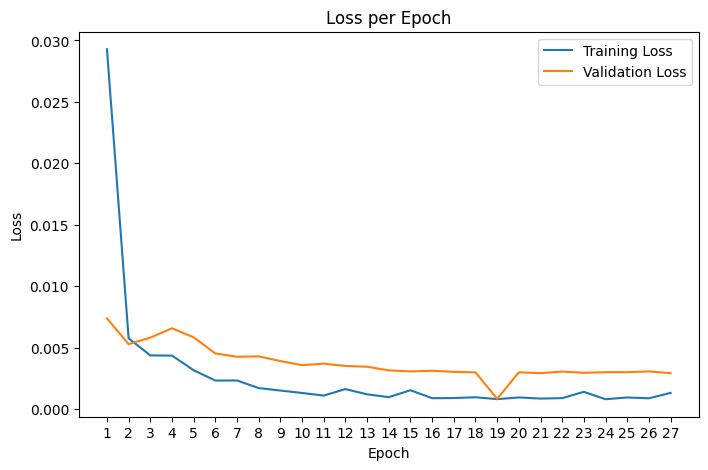

In [33]:
# Create a list of epoch numbers starting from 1
epochs = range(1, len(scaled_train_loss_history) + 1)

# Plot the training loss history
if len(epochs) > 30:
  plt.figure(figsize=(20,5))
else:
  plt.figure(figsize=(8,5))
plt.plot(epochs, scaled_train_loss_history)
plt.plot(epochs, scaled_val_loss_history)
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.xticks(epochs) # Ensure ticks are at each epoch number
plt.show()

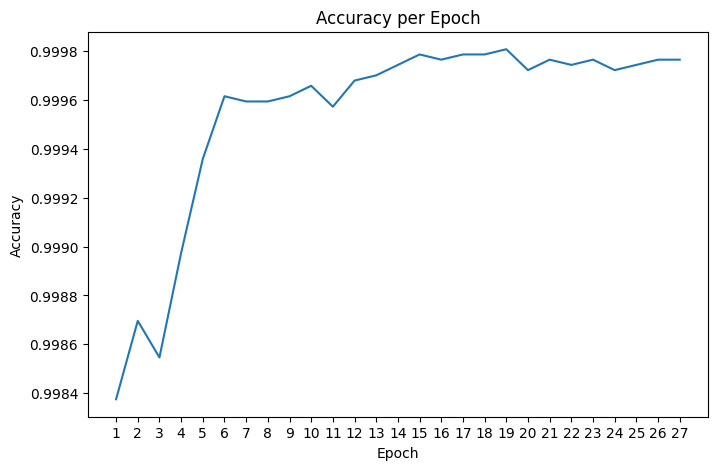

In [34]:
# Plot the validation accuracy history
if len(epochs) > 30:
  plt.figure(figsize=(20,5))
else:
  plt.figure(figsize=(8,5))
plt.plot(epochs, scaled_val_accuracy_history)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.xticks(epochs) # Ensure ticks are at each epoch number
plt.show()

In [35]:
# scalling on x test

X_test_scaled = scaler.fit_transform(X_test)
X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32)

# evaluating with scalled data
model = IoTModel() # Create an instance of the model
metrics = evaluate_model(model, X_test_scaled, y_test,scaled_best_weights)
print(metrics)

{'test_loss': 0.0009359324467368424, 'test_accuracy': 0.9998076558113098}


## Adding Dropout Regularization with scaled data

In [39]:
class IoTModel_Dropout(nn.Module):
    def __init__(self):
        super().__init__()
        # fully connected (linear) layers
        self.dropout0 = nn.Dropout(0.2)
        self.layer1 = nn.Linear(10, 10)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.layer2 = nn.Linear(10, 10)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.layer3 = nn.Linear(10,10)
        self.act3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.2)
        self.layer4 = nn.Linear(10, 10)
        self.act4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.2)
        self.output = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout0(x)
        x = self.act1(self.layer1(x))
        x = self.dropout1(x)
        x = self.act2(self.layer2(x))
        x = self.dropout2(x)
        x = self.act3(self.layer3(x))
        x = self.dropout3(x)
        x = self.act4(self.layer4(x))
        x = self.dropout4(x)
        x = self.sigmoid(self.output(x))
        return x

In [40]:
#confirm the parameters
model = IoTModel_Dropout()
print(model.parameters)

<bound method Module.parameters of IoTModel_Dropout(
  (dropout0): Dropout(p=0.2, inplace=False)
  (layer1): Linear(in_features=10, out_features=10, bias=True)
  (act1): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (act2): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (layer3): Linear(in_features=10, out_features=10, bias=True)
  (act3): ReLU()
  (dropout3): Dropout(p=0.2, inplace=False)
  (layer4): Linear(in_features=10, out_features=10, bias=True)
  (act4): ReLU()
  (dropout4): Dropout(p=0.2, inplace=False)
  (output): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)>


In [41]:
model = IoTModel_Dropout()
acc, weights, train_loss_history, val_accuracy_history, val_loss_history = model_train_adamw(model, X_train_scaled, y_train, X_val_scaled, y_val)

dropout_best_acc = acc
dropout_best_weights = weights
dropout_train_loss_history = train_loss_history
dropout_val_accuracy_history = val_accuracy_history
dropout_val_loss_history = val_loss_history

print(f"\nBest validation accuracy: {dropout_best_acc:.2%}")

Epoch 001/50 | train_loss=0.2166 | val_loss=0.0942 | val_acc=0.9864


Epoch 002/50 | train_loss=0.1270 | val_loss=0.0336 | val_acc=0.9932


Epoch 003/50 | train_loss=0.1131 | val_loss=0.0315 | val_acc=0.9860


Epoch 004/50 | train_loss=0.1122 | val_loss=0.0283 | val_acc=0.9928


Epoch 005/50 | train_loss=0.1020 | val_loss=0.0271 | val_acc=0.9932


Epoch 006/50 | train_loss=0.0937 | val_loss=0.0278 | val_acc=0.9923


Epoch 007/50 | train_loss=0.1003 | val_loss=0.0309 | val_acc=0.9881


Epoch 008/50 | train_loss=0.0988 | val_loss=0.0288 | val_acc=0.9929


Epoch 009/50 | train_loss=0.0973 | val_loss=0.0249 | val_acc=0.9930


Epoch 010/50 | train_loss=0.0984 | val_loss=0.0344 | val_acc=0.9862


Epoch 011/50 | train_loss=0.1004 | val_loss=0.0295 | val_acc=0.9927


Epoch 012/50 | train_loss=0.0898 | val_loss=0.0323 | val_acc=0.9869


Epoch 013/50 | train_loss=0.0874 | val_loss=0.0410 | val_acc=0.9891


Epoch 014/50 | train_loss=0.0876 | val_loss=0.0312 | val_acc=0.9924


Epoch 015/50 | train_loss=0.0904 | val_loss=0.0237 | val_acc=0.9926


Epoch 016/50 | train_loss=0.0943 | val_loss=0.0308 | val_acc=0.9931


Epoch 017/50 | train_loss=0.0938 | val_loss=0.0381 | val_acc=0.9924


Epoch 018/50 | train_loss=0.0915 | val_loss=0.0320 | val_acc=0.9889


Epoch 019/50 | train_loss=0.0914 | val_loss=0.0301 | val_acc=0.9876


Epoch 020/50 | train_loss=0.0838 | val_loss=0.0321 | val_acc=0.9913


Epoch 021/50 | train_loss=0.0885 | val_loss=0.0336 | val_acc=0.9869


Epoch 022/50 | train_loss=0.0858 | val_loss=0.0272 | val_acc=0.9907


Epoch 023/50 | train_loss=0.0885 | val_loss=0.0264 | val_acc=0.9920
⏹ Early stopping triggered at epoch 22

Best validation accuracy: 99.32%


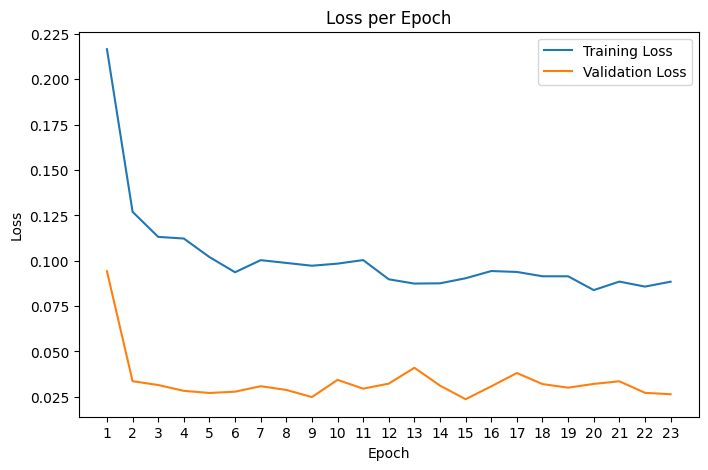

In [42]:
# Create a list of epoch numbers starting from 1
epochs = range(1, len(dropout_train_loss_history) + 1)

# Plot the training loss history
if len(epochs) > 30:
  plt.figure(figsize=(20,5))
else:
  plt.figure(figsize=(8,5))
plt.plot(epochs, dropout_train_loss_history)
plt.plot(epochs, dropout_val_loss_history)
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.xticks(epochs) # Ensure ticks are at each epoch number
plt.show()

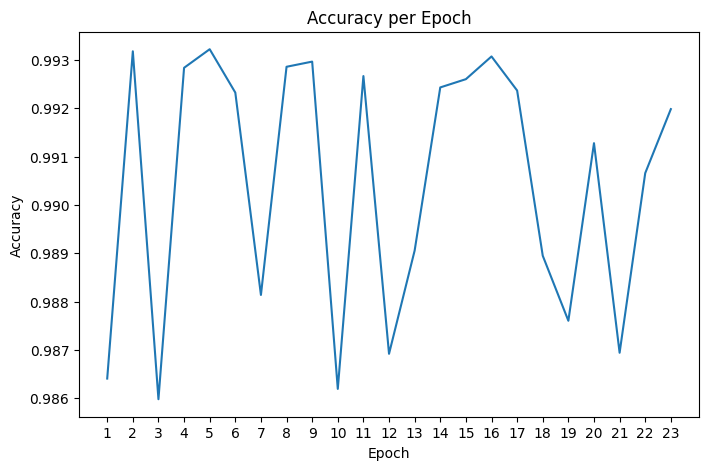

In [43]:
# Plot the validation accuracy history
if len(epochs) > 30:
  plt.figure(figsize=(20,5))
else:
  plt.figure(figsize=(8,5))
plt.plot(epochs, dropout_val_accuracy_history)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.xticks(epochs) # Ensure ticks are at each epoch number
plt.show()

In [44]:
metrics = evaluate_model(model, X_test_scaled, y_test, dropout_best_weights)
print(metrics)

{'test_loss': 0.022789139300584793, 'test_accuracy': 0.9929254055023193}


In [45]:
print(f"\nBest validation accuracy for original model: {adamw_best_acc:.2%}")
print(f"\nBest validation accuracy for model with scaled data: {scaled_best_acc:.2%}")
print(f"\nBest validation accuracy for model with dropout: {dropout_best_acc:.2%}")



Best validation accuracy for original model: 99.75%

Best validation accuracy for model with scaled data: 99.98%

Best validation accuracy for model with dropout: 99.32%
